In [21]:
from IPython.display import display,HTML
c1,c2,f1,f2,fs1,fs2=\
'#11ff66','#6611ff','Wallpoet','Orbitron',20,10
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' 
    style='font-family:"""+font+\
    """; color:"""+fontcolor+\
    """; font-size:"""+str(fontsize)+"""px;'>
    %s</h1>"""%string))

In [22]:
dhtml('Code Modules, Setting, & Functions')

In [23]:
import warnings,imageio,urllib
import tensorflow as tf,pylab as pl
import pandas as pd,numpy as np
import tensorflow.keras.layers as tkl
import tensorflow.keras.utils as tku
import tensorflow.keras.callbacks as tkc
import tensorflow_datasets as tfds
from sklearn.metrics import \
classification_report,confusion_matrix
from IPython.core.magic import register_line_magic

In [24]:
warnings.filterwarnings('ignore')
pd.set_option('precision',3)
tf.keras.backend.set_floatx('float64')
fw='weights.best.hdf5'
buffer_size,batch_size=10000,64
pixels,pixels2=28,32
num_classes=10

In [25]:
@register_line_magic
def display_examples(pars):
    pars=pars.split()
    data,n=pars[0],int(pars[1])
    if data=='mnist': data=mnist_test
    if data=='cifar': data=cifar_test
    batch=next(iter(data.batch(n)))
    images=batch['image'].numpy()
    labels=batch['label'].numpy() 
    fig=pl.figure(figsize=(2*n//3,4.5))
    for i in range(n):
        ax=fig.add_subplot(3,n//3,i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(np.squeeze(images[i]),
                  cmap='bone')
        ax.text(.85,.15,'{}'.format(labels[i]), 
                fontdict={'color':c1,'fontsize':30},
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
    pl.show()

In [26]:
@register_line_magic
def display_reports(data):
    global model,fw,buffer_size,c2,f2,fs2
    model.load_weights(fw)
    if data=='mnist': data=mnist_test
    if data=='cifar': data=cifar_test
    test_results=model.evaluate(data.batch(buffer_size))
    dhtml('\ntest accuracy: {:.2f}%'\
          .format(test_results[1]*100),
          c2,f2,fs2)
    batch=next(iter(data.batch(buffer_size)))
    y_test=batch[1].numpy()
    py_test=np.argmax(
        model.predict(data.batch(buffer_size)),
                      axis=-1)
    dhtml('Classification Report',c2,f2,fs2)
    print(classification_report(y_test,py_test))
    dhtml('Confusion Matrix',c2,f2,fs2)
    print(confusion_matrix(y_test,py_test))

In [27]:
def cb(fw):
    early_stopping=\
    tkc.EarlyStopping(monitor='val_loss',
                      patience=10,verbose=2)
    checkpointer=\
    tkc.ModelCheckpoint(filepath=fw,
                        save_best_only=True,verbose=2)
    lr_reduction=\
    tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                          patience=5,factor=.75)
    return [checkpointer,early_stopping,
            lr_reduction]

In [28]:
def history_plot(fit_history):
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color=c1,label='train')
    pl.plot(fit_history.history[keys[2]],
            color=c2,label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color=c1,label='train')
    pl.plot(fit_history.history[keys[3]],
            color=c2,label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

In [29]:
dhtml('Data Processing')

In [30]:
mnist=tfds.builder('mnist')
mnist.download_and_prepare()
ds=mnist.as_dataset(shuffle_files=False,
            split=['train','test'])
mnist_train,mnist_test=ds[0],ds[1]

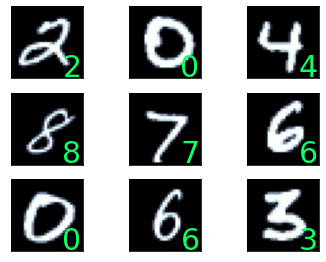

In [31]:
dhtml(mnist.info.features['image'],c2,f2,fs2)
dhtml(mnist.info.features['label'],c2,f2,fs2)
%display_examples mnist 9

In [32]:
mnist_train=mnist_train.map(
    lambda item:(tf.cast(item['image'],tf.float32)/255., 
                 tf.cast(item['label'],tf.int32)))
mnist_test=mnist_test.map(
    lambda item:(tf.cast(item['image'],tf.float32)/255., 
                  tf.cast(item['label'],tf.int32)))
tf.random.set_seed(123)
mnist_train=mnist_train\
.shuffle(buffer_size=buffer_size,
         reshuffle_each_iteration=False)
mnist_valid=mnist_train.take(buffer_size).batch(batch_size)
mnist_train=mnist_train.skip(buffer_size).batch(batch_size)

In [33]:
cifar=tfds.builder('cifar10')
cifar.download_and_prepare()
ds=cifar.as_dataset(shuffle_files=False,
                    split=['train','test'])
cifar_train,cifar_test=ds[0],ds[1]

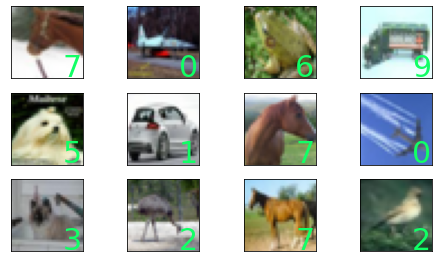

In [34]:
dhtml(cifar.info.features['image'],c2,f2,fs2)
dhtml(cifar.info.features['label'],c2,f2,fs2)
%display_examples cifar 12

In [35]:
cifar_train=cifar_train.map(
    lambda item:(tf.cast(item['image'],tf.float32)/255., 
                 tf.cast(item['label'],tf.int32)))
cifar_test=cifar_test.map(
    lambda item:(tf.cast(item['image'],tf.float32)/255., 
                  tf.cast(item['label'],tf.int32)))
tf.random.set_seed(123)
cifar_train=cifar_train\
.shuffle(buffer_size=buffer_size,
         reshuffle_each_iteration=False)
cifar_valid=cifar_train.take(buffer_size).batch(batch_size)
cifar_train=cifar_train.skip(buffer_size).batch(batch_size)

In [36]:
dhtml('CNN Construction. One Channel')

In [37]:
model=tf.keras.Sequential()
model.add(tkl.Input((pixels,pixels,1),
                    name='input'))
model.add(tkl.Conv2D(
    filters=32,kernel_size=(7,7),
    strides=(1,1),padding='same',
    name='conv_1'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_1'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),name='pool_1'))
model.add(tkl.Dropout(.25,name='drop_1'))
model.add(tkl.Conv2D(
    filters=96,kernel_size=(7,7),
    strides=(1,1),padding='same',
    name='conv_2'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_2'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),name='pool_2'))
model.add(tkl.Dropout(.25,name='drop_2'))
model.add(tkl.Conv2D(
    filters=512,kernel_size=(7,7),
    strides=(1,1),padding='same',
    name='conv_3'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_3'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),name='pool_3'))
model.add(tkl.Dropout(.25,name='drop_3'))
model.compute_output_shape(
    input_shape=(batch_size,pixels,pixels,1))

TensorShape([64, 3, 3, 512])

In [38]:
model.add(tkl.GlobalMaxPooling2D(name='gmpool'))   
model.add(tkl.Dense(512,name='dense_1'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_4'))
model.add(tkl.Dropout(.5,name='drop_4'))
model.compute_output_shape(
    input_shape=(batch_size,pixels,pixels,1))

TensorShape([64, 512])

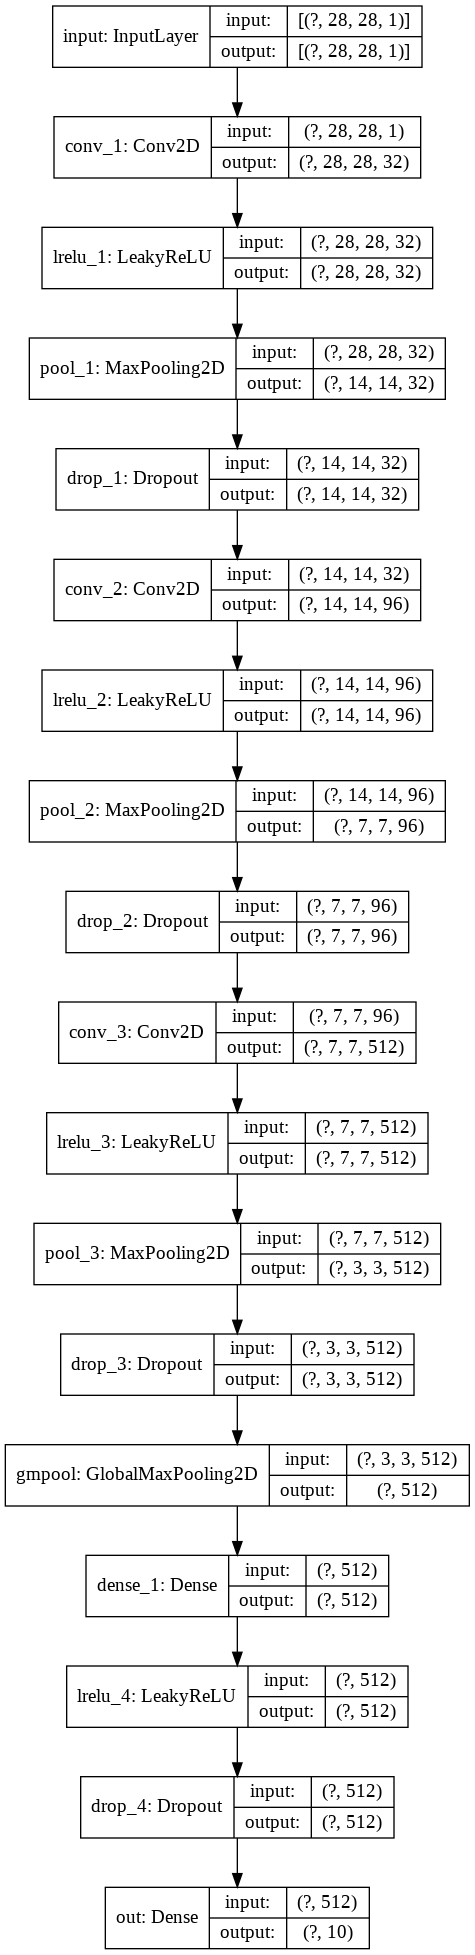

In [39]:
model.add(tkl.Dense(num_classes,
                    activation='softmax',
                    name='out'))
tku.plot_model(model,show_shapes=True)

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history=model.fit(mnist_train,epochs=50,shuffle=True, 
                  validation_data=mnist_valid,
                  callbacks=cb(fw))

Epoch 1/50
    782/Unknown - 294s 376ms/step - loss: 0.2356 - accuracy: 0.9225
Epoch 00001: val_loss improved from inf to 0.06442, saving model to weights.best.hdf5
782/782 [==============================] - 325s 415ms/step - loss: 0.2356 - accuracy: 0.9225 - val_loss: 0.0644 - val_accuracy: 0.9804
Epoch 2/50
782/782 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9804
Epoch 00002: val_loss improved from 0.06442 to 0.03567, saving model to weights.best.hdf5
782/782 [==============================] - 325s 415ms/step - loss: 0.0641 - accuracy: 0.9804 - val_loss: 0.0357 - val_accuracy: 0.9892
Epoch 3/50
782/782 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9849
Epoch 00003: val_loss did not improve from 0.03567
782/782 [==============================] - 324s 415ms/step - loss: 0.0501 - accuracy: 0.9849 - val_loss: 0.0415 - val_accuracy: 0.9872
Epoch 4/50
782/782 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9875
E

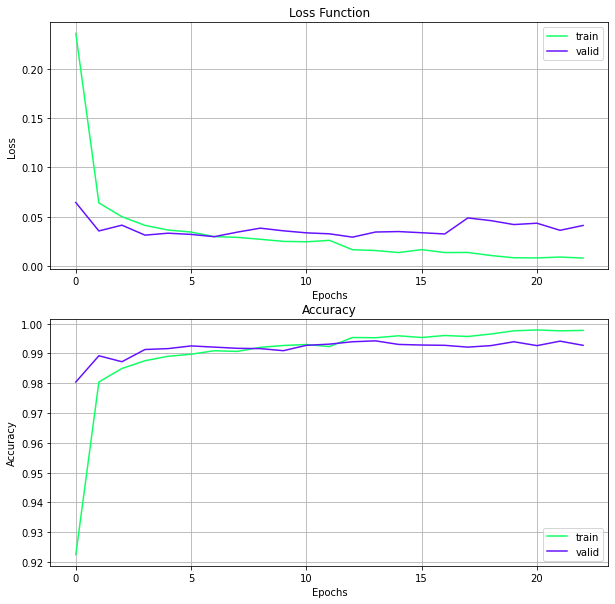

In [41]:
history_plot(history)

In [42]:
%display_reports mnist

1/1 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9944


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1133    0    1    0    0    0    1    0    0]
 [   0    0 1024    1    0    0    0    7    0    0]
 [   0    0    0 1009    0    0    0    0    1    0]
 [   0    0    0    0  974    0    1    2    0    5]
 [   0    0    0    5    0  884    1    0    0    2]
 [   4    2    0    0    1    0  951    0    0    0]
 [   0    2    1    1    0    0    0 1023    0    1]
 [   2    0    1    0    0    1    0    0  968    2]
 [   0    0    0    0    6    1    0    2    0 1000]]


In [55]:
dhtml('NN Construction. Three Channels')

In [58]:
model=tf.keras.Sequential()
model.add(tkl.Input((pixels2,pixels2,3),
                    name='input'))
model.add(tkl.Conv2D(
    filters=32,kernel_size=(5,5),
    strides=(1,1),padding='same',
    name='conv_1'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_1'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),name='pool_1'))
model.add(tkl.Dropout(.25,name='drop_1'))
model.add(tkl.Conv2D(
    filters=196,kernel_size=(5,5),
    strides=(1,1),padding='same',
    name='conv_2'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_2'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),name='pool_2'))
model.add(tkl.Dropout(.25,name='drop_2'))
model.compute_output_shape(
    input_shape=(batch_size,pixels2,pixels2,3))

TensorShape([64, 8, 8, 196])

In [59]:
model.add(tkl.GlobalMaxPooling2D(name='gmpool'))   
model.add(tkl.Dense(1024,name='dense_1'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_3'))
model.add(tkl.Dropout(.5,name='drop_3'))
model.compute_output_shape(
    input_shape=(batch_size,pixels2,pixels2,3))

TensorShape([64, 1024])

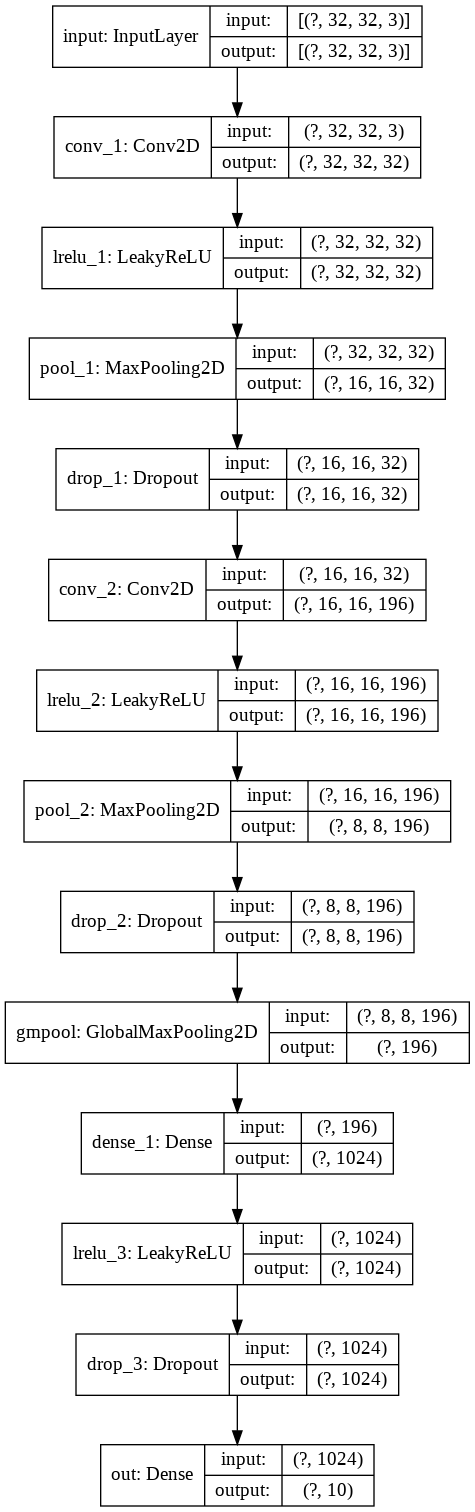

In [60]:
model.add(tkl.Dense(num_classes,
                    activation='softmax',
                    name='out'))
tku.plot_model(model,show_shapes=True)

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses\
              .SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history=model.fit(cifar_train,epochs=50,shuffle=True, 
                  validation_data=cifar_valid,
                  callbacks=cb(fw))

Epoch 1/50
    625/Unknown - 88s 141ms/step - loss: 1.7272 - accuracy: 0.3614
Epoch 00001: val_loss improved from inf to 1.43704, saving model to weights.best.hdf5
625/625 [==============================] - 102s 164ms/step - loss: 1.7272 - accuracy: 0.3614 - val_loss: 1.4370 - val_accuracy: 0.4858
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 1.3665 - accuracy: 0.5022
Epoch 00002: val_loss improved from 1.43704 to 1.23650, saving model to weights.best.hdf5
625/625 [==============================] - 102s 164ms/step - loss: 1.3665 - accuracy: 0.5022 - val_loss: 1.2365 - val_accuracy: 0.5731
Epoch 3/50
625/625 [==============================] - ETA: 0s - loss: 1.2201 - accuracy: 0.5600
Epoch 00003: val_loss improved from 1.23650 to 1.12321, saving model to weights.best.hdf5
625/625 [==============================] - 102s 163ms/step - loss: 1.2201 - accuracy: 0.5600 - val_loss: 1.1232 - val_accuracy: 0.6141
Epoch 4/50
625/625 [==============================] - ETA: 

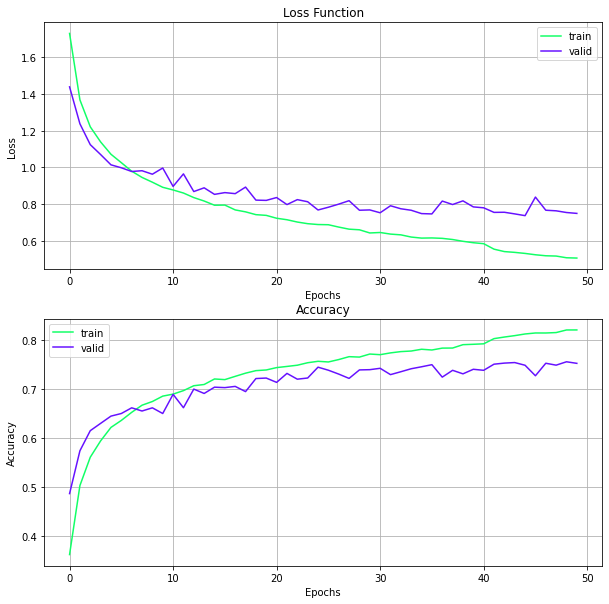

In [50]:
history_plot(history)

In [54]:
%display_reports cifar

1/1 [==============================] - 0s 13ms/step - loss: 0.7567 - accuracy: 0.7414


              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1000
           1       0.88      0.82      0.85      1000
           2       0.66      0.69      0.67      1000
           3       0.56      0.51      0.54      1000
           4       0.63      0.78      0.70      1000
           5       0.62      0.69      0.66      1000
           6       0.88      0.67      0.76      1000
           7       0.85      0.76      0.80      1000
           8       0.85      0.85      0.85      1000
           9       0.78      0.85      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



[[798  13  41  25  15   7   3  10  62  26]
 [ 10 818   5  13   3   6   3   3  17 122]
 [ 49   2 685  53  99  54  24  17  13   4]
 [ 34   6  65 511  89 210  31  24   9  21]
 [ 18   2  64  47 781  36  14  30   6   2]
 [ 13   2  48 119  56 694  13  36   9  10]
 [ 12   2  78  88  93  43 665   5   8   6]
 [ 15   3  29  27  88  55   3 761   2  17]
 [ 57  21  11  14  10   6   2   4 847  28]
 [ 26  63  10   8   4   6   1   5  23 854]]
